In [1]:
"""
File:   PCM.ipynb
Author: Aaryan Kumar
Date:   11/02/2021
Desc:   Implementation of Probablistic-C-Means algorithm
    
"""

'\nFile:   PCM.ipynb\nAuthor: Aaryan Kumar\nDate:   11/02/2021\nDesc:   Implementation of Probablistic-C-Means algorithm\n    \n'

In [2]:
""" =======================  Import dependencies ========================== """
"""
Code adapted from: https://github.com/scikit-fuzzy/scikit-fuzzy/blob/master/skfuzzy/cluster/_cmeans.py
"""
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn import datasets 

plt.close('all') #close any open plots

In [3]:
""" ======================  Function definitions ========================== """
# Used the code in Lecture Notes for EEL 5840 Course (University of Florida)
def _distance(data, centers):
    """
    Euclidean distance from each point to each cluster center.
    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.
    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.
    See Also
    --------
    scipy.spatial.distance.cdist
    """


    return cdist(data, centers).T

In [4]:

def _fp_coeff(u):

    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)

In [5]:
def _cmeans0(data, u_old, c, m, eta):
    """
    Single step in generic c-means clustering algorithm.
    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.
    Parameters inherited from cmeans()
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    nx_um = (1 - u_old) ** m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / (np.ones((data.shape[1],
                                    1)).dot(np.atleast_2d(um.sum(axis=1))).T)


    d = _distance(data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)



    jm = (um * d ** 2).sum() + (eta.sum() * nx_um.sum())

    u = (d/eta) ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return cntr, u, jm, d

In [6]:
def cmeans(data, c, eta, init, m=2, error=1e-3, maxiter=1000, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].
    Parameters
    ----------
    data : 2d array, size (S, N)
        Data to be clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.
    Returns
    -------
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.
    Notes
    -----
    The algorithm implemented is from Ross et al. [1]_.
    Fuzzy C-Means has a known problem with high dimensionality datasets, where
    the majority of cluster centers are pulled into the overall center of
    gravity. If you are clustering data with very high dimensionality and
    encounter this issue, another clustering method may be required. For more
    information and the theory behind this, see Winkler et al. [2]_.
    References
    ----------
    .. [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    .. [2] Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high
           dimensional spaces. 2012. Contemporary Theory and Pragmatic
           Approaches in Fuzzy Computing Utilization, 1.
    """
    # Setup u0
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0


    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m, eta)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u  

In [7]:
""" ======================  Variable Declaration ========================== """
#Set or load parameters here
n_samples = 1500

""" =======================  Generate Data ======================= """

#Blobs
blobs, y_blobs = datasets.make_blobs(n_samples=n_samples)
X = blobs
y = y_blobs
# Anisotropicly distributed blobs
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(blobs, transformation)
y_aniso = y_blobs

# Different variance blobs 
X_varied, y_varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5])

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))

In [8]:
""" ========================  Cluster the Data ============================= """
n_clusters = 3
m = 2
data = X.T
n = data.shape[1]
u0 = np.random.rand(n_clusters, n)
u0 /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
init = u0.copy()
u = np.fmax(u0, np.finfo(np.float64).eps)

# Calculate cluster centers
u2 = u.copy()
um = u2 ** m

data_T = data.T
cntr = um.dot(data_T) / (np.ones((data_T.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

d = cdist(data_T, cntr).T
d = np.fmax(d, np.finfo(np.float64).eps)

eta = (um * d ** 2).sum(axis=0) / um.sum(axis=0)
print(eta)


centers1, L = cmeans(X.T, n_clusters, eta, init)

[142.83401802  89.17487509  71.54835752 ... 109.80350369  94.73739517
   6.30831267]


In [9]:
#IMPLEMENTATION

data = X_aniso.T
n = data.shape[1]
u0 = np.random.rand(n_clusters, n)
u0 /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
init = u0.copy()
u = np.fmax(u0, np.finfo(np.float64).eps)

# Calculate cluster centers
u2 = u.copy()
um = u2 ** m

data_T = data.T
cntr = um.dot(data_T) / (np.ones((data_T.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

d = cdist(data_T, cntr).T
d = np.fmax(d, np.finfo(np.float64).eps)

eta = (um * d ** 2).sum(axis=0) / um.sum(axis=0)
print(eta)

centers2, L_aniso = cmeans(X_aniso.T, n_clusters, eta, init)


data = X_varied.T
n = data.shape[1]
u0 = np.random.rand(n_clusters, n)
u0 /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
init = u0.copy()
u = np.fmax(u0, np.finfo(np.float64).eps)

# Calculate cluster centers
u2 = u.copy()
um = u2 ** m

data_T = data.T
cntr = um.dot(data_T) / (np.ones((data_T.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

d = cdist(data_T, cntr).T
d = np.fmax(d, np.finfo(np.float64).eps)

eta = (um * d ** 2).sum(axis=0) / um.sum(axis=0)
print(eta)

centers3, L_varied = cmeans(X_varied.T, n_clusters, eta, init)


data = X_filtered.T
n = data.shape[1]
u0 = np.random.rand(n_clusters, n)
u0 /= np.ones((n_clusters, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
init = u0.copy()
u = np.fmax(u0, np.finfo(np.float64).eps)

# Calculate cluster centers
u2 = u.copy()
um = u2 ** m

data_T = data.T
cntr = um.dot(data_T) / (np.ones((data_T.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

d = cdist(data_T, cntr).T
d = np.fmax(d, np.finfo(np.float64).eps)

eta = (um * d ** 2).sum(axis=0) / um.sum(axis=0)
print(eta)

center_final, L_filtered = cmeans(X_filtered.T, n_clusters, eta, init)



[188.75657503 149.76424571 124.38126431 ... 167.18640203 148.62920552
   0.8016363 ]
[ 29.40088143  25.45528818  56.52571901 ...  20.34397702  97.58185668
 137.89037911]
[ 10.31506776   5.57908431  14.83567153   6.68142416  23.15698455
  12.45453922  10.62753178  35.32370649  25.58163832  22.26126606
  14.95107541   4.24621331   9.91328081  12.23953254  11.62406567
   5.62686488  10.50306456  10.43935637   4.39960403   9.06204787
  27.98726246  11.17249667   7.2119043   13.89279977   8.06972686
   4.99089704   8.31027489  10.93227537   9.3628303   10.90951146
   9.90041847   6.01467589   3.41211341   4.25065867  17.03951101
   5.94884309  28.49076962   6.45774479   8.99316377   9.49231198
  18.80522184  17.65997692  13.33165892   8.29667202  22.63165032
  17.29170954  11.91873027  15.31932525  25.84263516   6.73366947
   7.18293442  17.85495769  10.56959568   7.72541717  12.8072401
  18.7974523   12.52584649   6.82370228  12.54868818  16.21094601
   8.61948483  17.71104504   2.16684481

Text(0.5, 1.0, 'Unevenly Sized Blobs')

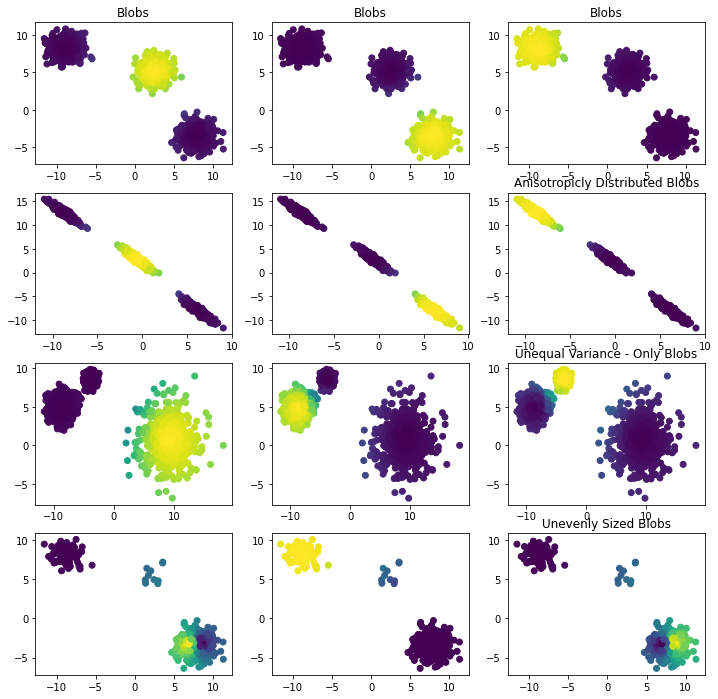

In [10]:
""" ========================  Plot Results ============================== """

""" This is where you should plot results"""
plt.figure(figsize=(12, 12))
plt.subplot(431)
plt.scatter(blobs[:, 0], blobs[:, 1], c=L[0,:])
plt.title("Blobs")
plt.subplot(432)
plt.scatter(blobs[:, 0], blobs[:, 1], c=L[1,:])
plt.title("Blobs")
plt.subplot(433)
plt.scatter(blobs[:, 0], blobs[:, 1], c=L[2,:])
plt.title("Blobs")

plt.subplot(434)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L_aniso[0,:])
plt.subplot(435)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L_aniso[1,:])
plt.subplot(436)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=L_aniso[2,:])
plt.title("Anisotropicly Distributed Blobs")

plt.subplot(437)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L_varied[0,:])
plt.subplot(438)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L_varied[1,:])
plt.subplot(439)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=L_varied[2,:])
plt.title("Unequal Variance - Only Blobs")

plt.subplot(4,3,10)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L_filtered[0,:])
plt.subplot(4,3,11)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L_filtered[1,:])
plt.subplot(4,3,12)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=L_filtered[2,:])
plt.title("Unevenly Sized Blobs")